# Entrenamiento y Evaluación de Modelos de Machine Learning con PyCaret y MLflow

Este notebook demuestra el uso de **PyCaret**, una biblioteca de aprendizaje automático automatizado (**AutoML**),
para entrenar y evaluar modelos de clasificación de sentimientos. PyCaret permite probar múltiples algoritmos
de forma rápida, optimizar hiperparámetros y generar métricas detalladas con solo unas pocas líneas de código.

Además, se integra **MLflow**, una plataforma de gestión del ciclo de vida de modelos de Machine Learning,
para rastrear experimentos, registrar métricas y facilitar la comparabilidad entre diferentes modelos entrenados.

In [1]:
# Para la primera ejecución del código, es necesario instalar las librerías requeridas.
# Descomenta la siguiente línea y ejecútala si aún no tienes las dependencias instaladas.
# !pip install pandas mlflow==2.16.0 pickle5 imbalanced-learn pycaret scikit-learn

In [2]:
#Importamos las librerias necesarias
import pandas as pd
import mlflow
import pickle
from collections import Counter
from pycaret.classification import *
from imblearn.over_sampling import RandomOverSampler
from logic.text_processing import TextProcessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# Cargamos el conjunto de datos de entrenamiento desde un archivo CSV
data_train = pd.read_csv('data/tass/tass2018_es_train.csv', sep=',')

# Cargamos el conjunto de datos de prueba desde un archivo CSV
data_test = pd.read_csv('data/tass/tass2018_es_test.csv', sep=',')

# Combinamos ambos conjuntos de datos en un solo DataFrame
data_bow = pd.concat([data_train, data_test])

# Mostramos las primeras filas del DataFrame combinado para inspeccionar los datos
data_bow.head()

,tweetid,user,content,date,lang,sentiment/polarity/value
0,768213876278165504,OnceBukowski,-Me caes muy bien \r\n-Tienes que jugar más pa...,2016-08-23 22:30:35,es,NONE
1,768213567418036224,anahorxn,@myendlesshazza a. que puto mal escribo\r\n\r\...,2016-08-23 22:29:21,es,N
2,768212591105703936,martitarey13,@estherct209 jajajaja la tuya y la d mucha gen...,2016-08-23 22:25:29,es,N
3,768221670255493120,endlessmilerr,Quiero mogollón a @AlbaBenito99 pero sobretodo...,2016-08-23 23:01:33,es,P
4,768221021300264964,JunoWTFL,Vale he visto la tia bebiendose su regla y me ...,2016-08-23 22:58:58,es,N


In [4]:
# Creamos una instancia de la clase TextProcessing, para procesar texto.
tp = TextProcessing()

# Creamos una instancia de LabelEncoder, utilizada para convertir etiquetas categóricas en valores numéricos.
le = LabelEncoder()

Language: Text Processing
es: ['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [5]:
# Aplicamos la transformación de texto a cada fila de la columna 'content' del DataFrame.
x = [tp.transformer(row) for row in data_bow['content'].tolist()]

# Extraemos la columna de etiquetas 'sentiment/polarity/value'
y = data_bow['sentiment/polarity/value']

In [6]:
# Creamos una instancia de CountVectorizer para convertir el texto en una representación numérica basada en la frecuencia de palabras.
# - analyzer='word': Se procesan palabras individuales.
# - ngram_range=(1, 3): Se consideran unigramas (palabras individuales), bigramas (pares de palabras) y trigramas (tres palabras consecutivas).
bow = CountVectorizer(analyzer='word', ngram_range=(1, 3))

# Se deja comentada una posible alternativa: TfidfVectorizer.
# tv = TfidfVectorizer(analyzer='word', ngram_range=(1, 3))

In [7]:
# Convertimos el texto procesado en una representación numérica mediante el modelo Bag of Words (BoW).
# 'fit_transform()' ajusta el vectorizador a los datos y luego los transforma en una matriz dispersa de características.
x = bow.fit_transform(x)

In [8]:
# Convertimos la matriz dispersa a una matriz densa de tipo numpy array.
x.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
# Contamos la cantidad de ocurrencias de cada categoría en 'y' y las mostramos ordenadas
print('**Sample train:', sorted(Counter(y).items()))

**Sample train: [('N', 637), ('NEU', 202), ('NONE', 201), ('P', 474)]


In [10]:
# Creamos una instancia de RandomOverSampler para balancear las clases.
# - random_state=10000: Se establece una semilla para reproducibilidad.
ros = RandomOverSampler(random_state=10000)

# Aplicamos el sobremuestreo para generar nuevas instancias de las clases minoritarias hasta igualar la cantidad de la clase mayoritaria.
x, y = ros.fit_resample(x, y)

# Mostramos la distribución de clases después del sobremuestreo.
print('**OverSample train:', sorted(Counter(y).items()))

**OverSample train: [('N', 637), ('NEU', 637), ('NONE', 637), ('P', 637)]


In [11]:
# Configuramos el entorno de PyCaret para el modelado de clasificación.
setup = setup(
    data=x,                 # Conjunto de datos de entrada (matriz de características)
    target=y,               # Variable objetivo (etiquetas de clasificación)
    session_id=123,         # Semilla aleatoria para garantizar reproducibilidad
    train_size=0.7,         # Porcentaje de datos usados para entrenamiento (70%)
    log_experiment=True,    # Habilita el registro de experimentos (mlflow)
    experiment_name='experiment_tass'  # Nombre del experimento para seguimiento (mlflow)
)

,Description,Value
0,Session id,123
1,Target,sentiment/polarity/value
2,Target type,Multiclass
3,Target mapping,"N: 0, NEU: 1, NONE: 2, P: 3"
4,Original data shape,"(2548, 37293)"
5,Transformed data shape,"(2548, 37293)"
6,Transformed train set shape,"(1783, 37293)"
7,Transformed test set shape,"(765, 37293)"
8,Numeric features,37292
9,Preprocess,True


2025/02/28 20:11:03 INFO mlflow.tracking.fluent: Experiment with name 'experiment_tass' does not exist. Creating a new experiment.


In [12]:
# Comparamos múltiples modelos de clasificación utilizando validación cruzada con 10 folds.
model = compare_models(fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:11:09
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8065,0.9368,0.8065,0.8364,0.8124,0.7420,0.7489,3.8060
et,Extra Trees Classifier,0.8043,0.9332,0.8043,0.8513,0.8096,0.7390,0.7536,3.9060
svm,SVM - Linear Kernel,0.7874,0.0000,0.7874,0.7908,0.7871,0.7166,0.7178,3.5780
ridge,Ridge Classifier,0.7841,0.0000,0.7841,0.7838,0.7821,0.7121,0.7133,3.5610
lr,Logistic Regression,0.7796,0.0000,0.7796,0.7789,0.7775,0.7061,0.7072,3.8840
dt,Decision Tree Classifier,0.7212,0.8142,0.7212,0.7198,0.7107,0.6283,0.6340,3.6340
lightgbm,Light Gradient Boosting Machine,0.7168,0.8890,0.7168,0.7122,0.7095,0.6224,0.6253,3.7350
gbc,Gradient Boosting Classifier,0.6349,0.0000,0.6349,0.6508,0.6315,0.5132,0.5199,6.6410
ada,Ada Boost Classifier,0.4251,0.0000,0.4251,0.4488,0.4212,0.2334,0.2389,3.8260
knn,K Neighbors Classifier,0.4049,0.6960,0.4049,0.4375,0.3444,0.2067,0.2263,3.8540


2025/02/28 20:25:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/28 20:25:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/28 20:25:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/28 20:25:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/28 20:25:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/28 20:25:18 

In [13]:
# Creamos un modelo de clasificación utilizando Random Forest (RF).
# Puedes reemplazar 'rf' con las iniciales del modelo que obtuvo mejores resultados en la comparación de PyCaret.
rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:25:20
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7877,0.9320,0.7877,0.8345,0.7969,0.7168,0.7287
1,0.7821,0.9238,0.7821,0.8111,0.7903,0.7095,0.7135
2,0.8436,0.9553,0.8436,0.8667,0.8445,0.7916,0.7997
3,0.7697,0.9176,0.7697,0.8096,0.7791,0.6930,0.7006
4,0.8708,0.9608,0.8708,0.8862,0.8741,0.8278,0.8311
5,0.8202,0.9534,0.8202,0.8541,0.8249,0.7605,0.7705
6,0.8146,0.9433,0.8146,0.8468,0.8196,0.7527,0.7618
7,0.7865,0.9209,0.7865,0.8093,0.7933,0.7152,0.7187
8,0.8146,0.9345,0.8146,0.8347,0.8171,0.7527,0.7586


2025/02/28 20:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [14]:
# Mostramos información detallada del modelo SVM entrenado.
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [15]:
# Muestra los hiperparámetros del modelo
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


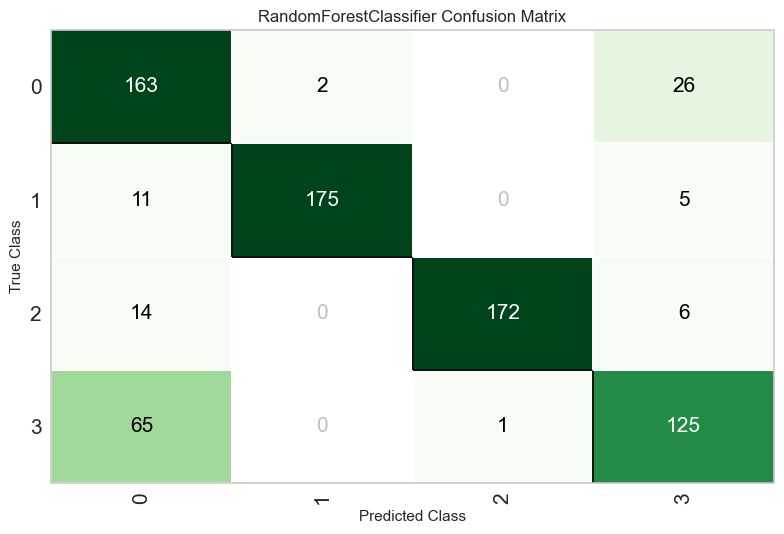

In [16]:
# Generamos la matriz de confusión del modelo SVM.
plot_model(rf, plot='confusion_matrix')

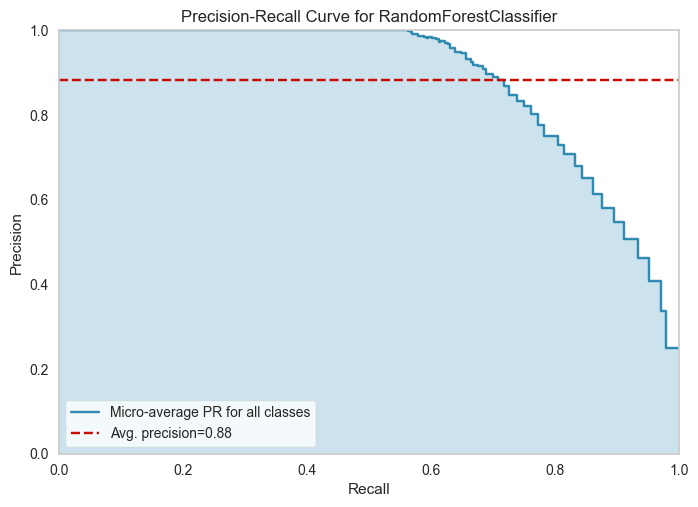

In [17]:
# Generamos la curva Precision-Recall del modelo entrenado.
plot_model(rf, plot='pr')

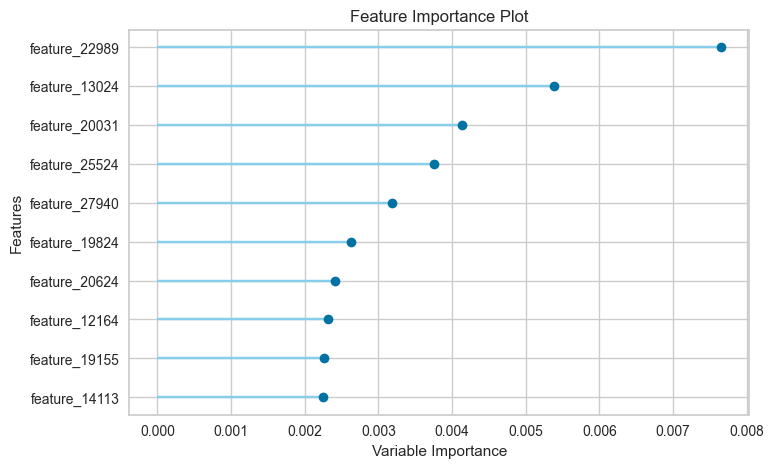

In [18]:
# Generamos un gráfico de importancia de características del modelo entrenado.
plot_model(rf, plot='feature')

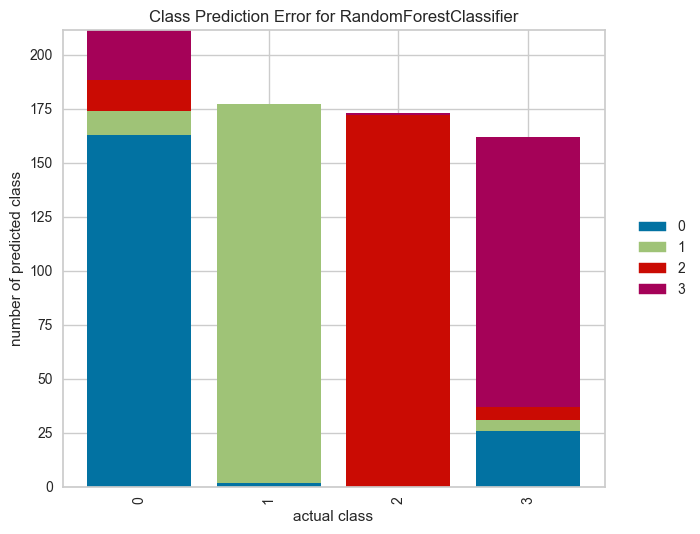

In [19]:
# Generamos el gráfico de error del modelo entrenado.
plot_model(rf, plot='error')

In [20]:
# Para visualizar los resultados del entrenamiento en la plataforma MLflow,
# es necesario ejecutar el siguiente comando en la terminal.
# Debes asegurarte de estar ubicado en el directorio del proyecto
# y tener activado el entorno virtual de trabajo.

# mlflow server --host 127.0.0.1 --port 8080